In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
import math

## Data Structuring

In [2]:
df_juan = pd.read_csv("../..//resources//csv//data//biometrics-juan.csv")
df_rocio = pd.read_csv("../..//resources//csv//data//biometrics-ro-2021-07-01.csv")
df_matias = pd.read_csv("../..//resources//csv//data//biometrics-matias.csv")
df_bren = pd.read_csv("../..//resources//csv//data//biometrics-bren.csv")
df_seba = pd.read_csv("../..//resources//csv//data//biometrics-seba.csv")

dfs = [df_rocio, df_juan, df_matias, df_bren, df_seba]

In [4]:
def standarize(df):
    df_to_standarize = df.copy()
    
    # remover las mediciones sin estímulo antes de la estandarización, para no afectar la desviación
    filterArousal = df_to_standarize['ArousalMean'] > 0
    filtered1 = df_to_standarize[filterArousal]

    # remover las mediciones para las que el sam no coincidió antes de la estandarización, para no afectar la desviación
    # filterSam = filtered1['MatchesSam'] == True
    # filtered = filtered1[filterSam]
    
    columns_to_standarize = ['HR', 'HRV', 'MicroSiemens']

    scaler = preprocessing.StandardScaler()
    standarized_df = scaler.fit_transform(df_to_standarize[columns_to_standarize])

    standarized_df_with_arousal = np.append(standarized_df, df_to_standarize[['ArousalMean']], axis=1)

    # Convert it to dataframe
    standarized_df_with_arousal = pd.DataFrame(standarized_df_with_arousal, columns=['HR', 'HRV', 'MicroSiemens', 'ArousalMean'])

    return standarized_df_with_arousal

In [5]:
# Se estandariza cada dataframe
standarized_dfs = list(map(standarize, dfs))

# Se los une a todos en un solo dataframe para entrenamiento luego de la estandarización
biometrics_df = pd.concat(standarized_dfs)

# sns.pairplot(biometrics_df, height=3.5);
# plt.show()

## Correlation Analysis

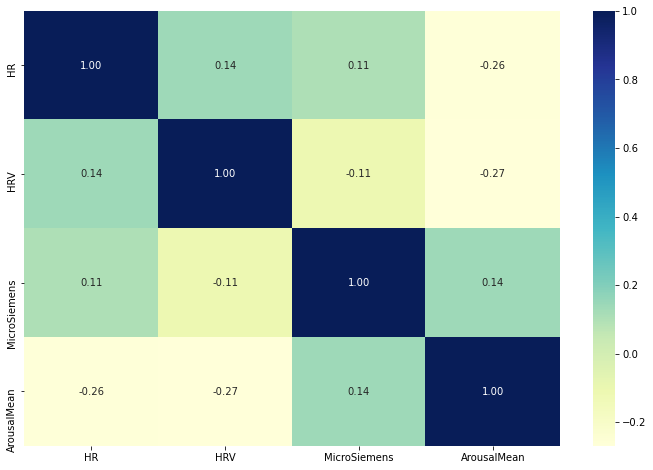

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(biometrics_df.corr(), annot=True, fmt=".2f", cmap='YlGnBu')
# plt.show()

In [7]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
def print_score(clf, X_train, X_test, y_train, y_test, train=True):
    '''
    v0.1 Follow the scikit learn library format in terms of input
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_train)
    if train:
        '''
        training performance
        '''
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, 
                                                                res)))
        print("Classification Report: \n {}\n".format(classification_report(y_train, 
                                                                            res)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, 
                                                                  res)))
        
        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        '''
        test performance
        '''
        res_test = clf.predict(X_test)
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, 
                                                                res_test)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, 
                                                                            res_test)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, 
                                                                  res_test)))

# Model creation

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [9]:
X = biometrics_df[['MicroSiemens', 'HR', 'HRV' ]].values
y = biometrics_df['ArousalMean'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [11]:
# Para poder usar un clasificador, los datos de la variable target deben ser discretos.
#Los convertimos a True-False (Aroused-NotAroused) con el fin de poder entrear un clasificador binario
def map_to_0_and_1(arousal):
    return 0 if arousal < 5 else 1

y_train_aroused = np.array(list(map(map_to_0_and_1, y_train)))
y_test_aroused = np.array(list(map(map_to_0_and_1, y_test)))

In [12]:
# clf = svm.SVC(C=0.1, gamma=0.01, kernel='rbf') los valores que dio el grid search
clf = svm.SVC(C=0.1, gamma=0.01, kernel='rbf')
clf.fit(X_train, y_train_aroused)

SVC(C=0.1, gamma=0.01)

In [13]:
print_score(clf, X_train, X_test, y_train_aroused, y_test_aroused, train=True)
print("\n******************************\n")
print_score(clf, X_train, X_test, y_train_aroused, y_test_aroused, train=False)

Train Result:

accuracy score: 0.7036

Classification Report: 
               precision    recall  f1-score   support

           0       0.70      1.00      0.83      2155
           1       0.00      0.00      0.00       908

    accuracy                           0.70      3063
   macro avg       0.35      0.50      0.41      3063
weighted avg       0.49      0.70      0.58      3063


Confusion Matrix: 
 [[2155    0]
 [ 908    0]]



/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Accuracy: 	 0.7036
Accuracy SD: 		 0.0012

******************************

Test Result:

accuracy score: 0.4948

Classification Report: 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       379
           1       0.00      0.00      0.00       387

    accuracy                           0.49       766
   macro avg       0.25      0.50      0.33       766
weighted avg       0.24      0.49      0.33       766


Confusion Matrix: 
 [[379   0]
 [387   0]]



/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# TRAIN cross validation
# y_train_pred = cross_val_predict(clf, X_train, y_train_aroused, cv=3)
# pd.DataFrame(confusion_matrix(y_train_aroused, y_train_pred),
#              columns=pd.MultiIndex.from_product([['Prediction'], ["Negative", "Positive"]]),
#              index=pd.MultiIndex.from_product([["Actual"], ["Negative", "Positive"]]))

# TEST cross validation
# y_test_pred = cross_val_predict(clf, X_test, y_test_aroused, cv=3)
# pd.DataFrame(confusion_matrix(y_test_aroused, y_test_pred),
#              columns=pd.MultiIndex.from_product([['Prediction'], ["Negative", "Positive"]]),
#              index=pd.MultiIndex.from_product([["Actual"], ["Negative", "Positive"]]))

# Grid Search

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [16]:
pipeline = Pipeline([('clf', svm.SVC(kernel='rbf', C=1, gamma=0.1))])

In [17]:
params = {'clf__C':(0.1, 0.5, 1, 2, 5, 10, 20), 'clf__gamma':(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1)}

In [18]:
svm_grid_rbf = GridSearchCV(pipeline, params, n_jobs=-1, cv=3, verbose=1, scoring='accuracy') 

In [19]:
svm_grid_rbf.fit(X_train, y_train_aroused)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    2.9s finished


GridSearchCV(cv=3, estimator=Pipeline(steps=[('clf', SVC(C=1, gamma=0.1))]),
             n_jobs=-1,
             param_grid={'clf__C': (0.1, 0.5, 1, 2, 5, 10, 20),
                         'clf__gamma': (0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1)},
             scoring='accuracy', verbose=1)

In [20]:
svm_grid_rbf.best_score_

0.703558602677114

In [21]:
best = svm_grid_rbf.best_estimator_.get_params() 

In [22]:
for k in sorted(params.keys()): 
    print('\t{0}: \t {1:.2f}'.format(k, best[k]))

	clf__C: 	 0.10
	clf__gamma: 	 0.00


In [23]:
# y_test_pred_grid = svm_grid_rbf.predict(X_test)

In [24]:
print_score(svm_grid_rbf, X_train, X_test, y_train_aroused, y_test_aroused, train=True)
print("\n******************************\n")
print_score(svm_grid_rbf, X_train, X_test, y_train_aroused, y_test_aroused, train=False)

Train Result:

accuracy score: 0.7036

Classification Report: 
               precision    recall  f1-score   support

           0       0.70      1.00      0.83      2155
           1       0.00      0.00      0.00       908

    accuracy                           0.70      3063
   macro avg       0.35      0.50      0.41      3063
weighted avg       0.49      0.70      0.58      3063


Confusion Matrix: 
 [[2155    0]
 [ 908    0]]

Fitting 3 folds for each of 49 candidates, totalling 147 fits


/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.4s finished


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.3s finished


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.3s finished


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.4s finished


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.6s finished


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 out of 147 | elapsed:    1.4s remaining:    0.3s


Average Accuracy: 	 0.7036
Accuracy SD: 		 0.0012

******************************

Test Result:

accuracy score: 0.4948

Classification Report: 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       379
           1       0.00      0.00      0.00       387

    accuracy                           0.49       766
   macro avg       0.25      0.50      0.33       766
weighted avg       0.24      0.49      0.33       766


Confusion Matrix: 
 [[379   0]
 [387   0]]



[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    1.6s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
